In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/") # https://github.com/glukicov/EDMTracking/blob/master/CommonUtils/CommonUtils.py
import CommonUtils as cu
import RUtils as ru

Welcome to JupyROOT 6.18/04


In [2]:
font_size=14 # for plots 

t_min = 4.5 # us  #TODO 30 for data 
t_max = 100 # us 
print("Starting and end times:", t_min, "to", t_max, "us")
p_min = 1800 # MeV 
p_max = 3100 # MeV 
print("Momentum cuts:", p_min, "to", p_max, "MeV")

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g-2 period ", round(g2period, 3), "us")
if(t_min<g2period):
    raise Exception("Set t_min>g2period for EDM reflection blidning to work")

bin_w = 10*1e-3 # 10 ns 
bin_n = int( round(g2period/bin_w) )
print("Setting bin width of", bin_w*1e3, "ns with", bin_n, "bins")

p0_count=(5000, 64, -0.4, 6)
print("Starting pars count (N, tau, A, phi):", *p0_count)
p0_theta_truth=(0.00, 0.17, 0.0)
print("Starting pars TRUTH theta (A_Bz, A_edm, c):", *p0_theta_truth)
p0_theta_blinded=(1.0, 1.0, 1.0) 
print("Starting pars theta blinded (A_Bz, A_edm, c):", *p0_theta_blinded)

Starting and end times: 4.5 to 100 us
Momentum cuts: 1800 to 3100 MeV
Magic omega set to 1.43934 MHz
g-2 period  4.365 us
Setting bin width of 10.0 ns with 437 bins
Starting pars count (N, tau, A, phi): 5000 64 -0.4 6
Starting pars TRUTH theta (A_Bz, A_edm, c): 0.0 0.17 0.0
Starting pars theta blinded (A_Bz, A_edm, c): 1.0 1.0 1.0


In [3]:
py_data = pd.read_hdf("../DATA/HDF/Sim/VLEDM_times.h5")
py_data

,index,trackT0,station,trackMomentum,trackMomentumY,mod_times,theta_y_mrad
0,2,80.277852,18,2544.615967,-59.835049,1.702021,-23.510041
1,3,42.755086,0,2182.920654,15.766864,3.467171,7.222704
2,6,10.879105,12,2120.369385,-8.798045,2.148458,-4.149274
3,18,11.418941,0,2252.512695,1.755878,2.688294,0.779520
4,23,59.367961,12,1947.019653,-30.768492,2.618750,-15.801551
...,...,...,...,...,...,...,...
1013831,5483773,34.607676,18,1846.266602,5.874977,4.050408,3.182074
1013832,5483776,70.492133,18,2016.368164,17.139523,0.646950,8.499990
1013833,5483788,33.120555,12,2171.714844,12.780183,2.563287,5.884767
1013834,5483789,82.543117,12,1940.134521,43.934719,3.967287,22.641322


In [4]:
py_t = py_data["trackT0"]
py_ang = py_data["theta_y_mrad"]

In [5]:
c_data = pd.read_csv("../DATA/misc/C_dump.txt")
c_data

,t,ang,tMod,weight
0,85.9590,-0.065543,-1.37629,0.978738
1,79.8036,0.192374,1.20095,1.018930
2,22.7368,0.154646,-3.46955,0.947264
3,11.1904,0.012543,2.44947,1.038990
4,14.5398,0.190097,-2.93384,0.955221
...,...,...,...,...
1013831,68.0943,-0.004946,-1.77557,0.972655
1013832,20.0208,-0.008251,2.54713,1.040580
1013833,18.9260,0.184442,1.45240,1.022940
1013834,15.6022,0.002545,-1.87144,0.971200


In [6]:
c_t = c_data["t"]
c_ang = c_data[" ang"]
c_tmod = c_data[" tMod"]
c_weight = c_data[" weight"]

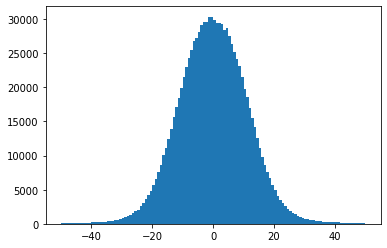

In [7]:
plt.hist(py_ang, bins=120, range=(-50,50));

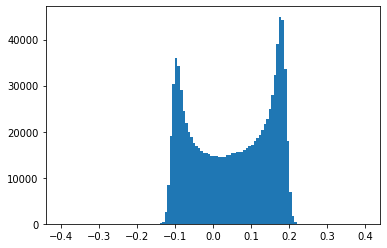

In [8]:
plt.hist(c_ang, bins=120, range=(-0.40,0.40));

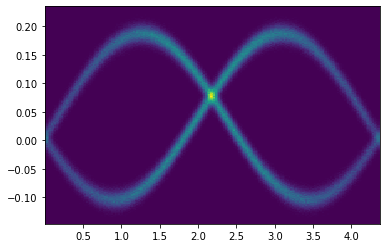

In [13]:
c_tmod_abs=np.abs(c_tmod)
h,xedges,yedges,image = plt.hist2d(c_tmod_abs, c_ang, weights=c_weight, bins=200);
# h,xedges,yedges,image = plt.hist2d(c_tmod_abs, c_ang,  bins=200);

In [14]:
h[2]

array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.999132,   0.998981,   0.999104,   1.998184,   2.997206,
         8.992   ,   8.991729,  11.989278,  25.976396,  18.983922,
        39.964514,  52.955447,  69.93835 ,  65.946021,  87.924856,
       101.915313, 130.894607, 126.901309, 115.91139 , 136.906

In [15]:
dataXY, binsXY, dBinXY = ru.hist2np(h, (xedges,yedges))

Using passed freq and edges


In [16]:
len(dataXY[1])

1019900

In [17]:
df_binned =cu.Profile(dataXY[0], dataXY[1], None, nbins=200, xmin=np.min(dataXY[0]), xmax=np.max(dataXY[0]), mean=True, only_binned=True)

In [18]:
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']

In [19]:
cu._phi=6.295
cu._LT=64.04

In [20]:
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, (-0.04, 0.0, 0.04))

Params: [-0.036718602 -0.000376647  0.042019303]
Errors: [5.128284752e-05 1.731358141e-04 4.942676139e-05]
𝝌2/dof=1.45


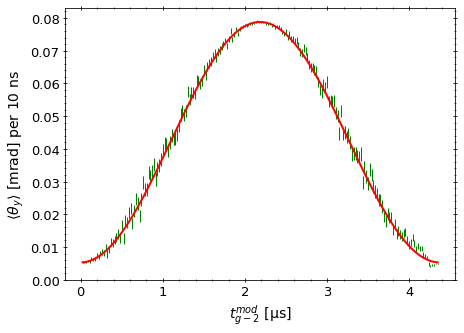

In [21]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)

In [18]:
# py_tmod = np.fmod(py_t - cu._phi/cu._omega, 2*g2period)-g2period
# py_tmod_abs=np.abs(py_tmod)

In [19]:
# py_weights=np.exp(py_tmod/cu._LT)

In [21]:
# xy_range=[ [0, 2*g2period], [-50, 50] ]
# plt.hist2d(py_tmod_abs, py_ang, weights=py_weights, bins=200, range=xy_range);

In [125]:
data=[]
binC=[1.5, 2.5, 3.5, 4.4]
freq=np.array([1, 1.1, 2, 3])

math.ceil(0.1)

D=len(freq.shape)
n_bins=len(freq)

for i_bin in range(n_bins):
    data.extend( (binC[i_bin]*np.ones(math.ceil(freq[i_bin]))) )

# np.array(data).flatten()
data

[1.5, 2.5, 2.5, 3.5, 3.5, 4.4, 4.4, 4.4]

In [89]:
data=[[], []]  
binC=[ [1, 2, 3, 4], [10, 20, 30]]
freq = np.array  ([[1, 2, 3, 4]   , [4, 5, 6]])

# D=2

D=len(x.shape)

for i_bin in range(n_bins):
    data.append(binC[i_bin])

data

IndexError: list index out of range

In [ ]:
for ix,iy in np.ndindex(freq.shape): # looping over x,y indices of a matrix 
            for i in range(0, int(freq[ix][iy])): # for that number of freq 
                    data[0].append(binC[0][ix]) #append to  X, and Y
                    data[1].append(binC[1][iy])